# CS440 Term Project

Data Source: https://finance.yahoo.com/

In [33]:
# Imports
import numpy as np
import pandas as pd
import math
import pandas_ta as pta
from matplotlib import pyplot as plt
%matplotlib inline
import talib as ta
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout, LeakyReLU, LSTM
from sklearn import model_selection
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from pandas.plotting import register_matplotlib_converters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()

## JP MORGAN

### Neural Network

In [34]:
# Read In Data
tsla = pd.read_csv('Data/JPM.csv', sep = ",")
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,49.833332,50.250000,48.083332,48.583332,25.561586,12019200
1,2000-01-04,47.083332,47.458332,46.125000,47.250000,25.000719,11723400
2,2000-01-05,46.833332,48.375000,46.000000,46.958332,24.846399,8714550
3,2000-01-06,46.750000,48.625000,46.500000,47.625000,25.199142,8369250
4,2000-01-07,48.416668,49.000000,47.333332,48.500000,25.662115,6571950


In [35]:
# Compute STOCH %K & %D

stochKD = pta.stoch(low = tsla.Low, high = tsla.High, close = tsla.Close, k = 14, d = 3, smooth_k = 9)
stochKD = stochKD.iloc[10: , :]
tsla = tsla.iloc[23: , :]

tsla.reset_index(inplace = True)
tsla = tsla.drop("index", 1)

tsla["%K"] = np.array(stochKD.STOCHk_14_3_9)
tsla["%D"] = np.array(stochKD.STOCHd_14_3_9)

# Compute Price 1 | 0 price in 10d (1 = up & 0 = down)

tenDay = []
for i in range(tsla.shape[0]-10):
    if(tsla.Close[i] - tsla.Close[i+10] < 0):
        tenDay.append(1)
    else:
        tenDay.append(0)
tsla = tsla.iloc[:-10]
tsla["Ten Day Gain"] = np.array(tenDay)


In [36]:
# Remove Columns
tsla = tsla.drop(["Adj Close", "Volume","Date", "%K", "%D"], 1)
tsla.head()

,Open,High,Low,Close,Ten Day Gain
0,55.000000,55.541668,54.375000,54.500000,0
1,54.791668,55.583332,54.500000,54.791668,0
2,56.041668,57.416668,56.000000,56.708332,0
3,56.625000,57.583332,54.958332,55.250000,0
4,55.416668,55.833332,54.250000,55.416668,0


In [37]:
n = tsla.shape[0]
splitRow = int(n * 0.80)
tsla4 = tsla.to_numpy()

# Splits
x_train = tsla4[:splitRow, :-1]
y_train = tsla4[:splitRow, -1]
x_test = tsla4[splitRow:, :-1]
y_test = tsla4[splitRow:, -1]

x_train

array([[55.      , 55.541668, 54.375   , 54.5     ],
       [54.791668, 55.583332, 54.5     , 54.791668],
       [56.041668, 57.416668, 56.      , 56.708332],
       ...,
       [87.709999, 88.940002, 87.5     , 88.050003],
       [88.599998, 90.07    , 88.599998, 89.82    ],
       [92.339996, 92.650002, 90.309998, 91.150002]])

In [38]:
# norm = MinMaxScaler()
# x_train = norm.fit_transform(x_train)

x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [39]:
model_tsla_nn = Sequential()
model_tsla_nn.add(Dense(12, input_dim=4, activation="relu"))
model_tsla_nn.add(Dense(12, activation="relu"))
model_tsla_nn.add(Dense(1, activation="softmax")) #SOFTMAX

In [40]:
model_tsla_nn.compile(loss = "binary_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [41]:
model_tsla_nn.fit(x_train, y_train, epochs = 10, batch_size = 1000)

Epoch 1/10
5/5 [==============================] - 0s 16ms/step - loss: 7.9494 - accuracy: 0.5441
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 6.6394 - accuracy: 0.5441
Epoch 3/10
5/5 [==============================] - 0s 2ms/step - loss: 5.3783 - accuracy: 0.5441
Epoch 4/10
5/5 [==============================] - 0s 3ms/step - loss: 4.1506 - accuracy: 0.5441
Epoch 5/10
5/5 [==============================] - 0s 4ms/step - loss: 2.9385 - accuracy: 0.5441
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 1.7835 - accuracy: 0.5441
Epoch 7/10
5/5 [==============================] - 0s 3ms/step - loss: 0.9143 - accuracy: 0.5441
Epoch 8/10
5/5 [==============================] - 0s 3ms/step - loss: 0.7381 - accuracy: 0.5441
Epoch 9/10
5/5 [==============================] - 0s 3ms/step - loss: 0.9115 - accuracy: 0.5441
Epoch 10/10
5/5 [==============================] - 0s 3ms/step - loss: 0.8996 - accuracy: 0.5441


In [42]:
pred_tsla_nn = model_tsla_nn.predict(x_test)
acc_tsla_nn = accuracy_score(pred_tsla_nn, y_test)
acc_tsla_nn

0.5643835616438356

### Logistic Regression

In [43]:
# Read In Data
tsla = pdr.get_data_yahoo('JPM', '2000-01-03', '2021-11-17')
tsla2 = tsla.dropna()
tsla2 = tsla2.iloc[:,:4]
tsla2.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close
Date,,,,
2000-01-03,49.833332,50.250000,48.083332,48.583332
2000-01-04,47.083332,47.458332,46.125000,47.250000
2000-01-05,46.833332,48.375000,46.000000,46.958332
2000-01-06,46.750000,48.625000,46.500000,47.625000
2000-01-07,48.416668,49.000000,47.333332,48.500000


In [44]:
tsla2['S_10'] = tsla2['Close'].rolling(window = 14).mean()
tsla2['Corr'] = tsla2['Close'].rolling(window = 14).corr(tsla2['S_10'])
tsla2['RSI'] = ta.RSI(np.array(tsla2['Close']), timeperiod = 14)
# The difference between the open price of yesterday and today
tsla2['Open-Close'] = tsla2['Open'] - tsla2['Close'].shift(1)
# The difference close price of yesterday and the open price of today
tsla2['Open-Open'] = tsla2['Open'] - tsla2['Open'].shift(1)
tsla2 = tsla2.dropna()
X = tsla2.iloc[:,:9]

In [45]:
y = np.where(tsla2['Close'].shift(-1) > tsla2['Close'],1,-1)

In [46]:
split = int(0.7 * len(tsla2))
X_train, X_test, y_train, y_test = X[:split], X[split:], y[:split], y[split:]

In [47]:
model = LogisticRegression()
model = model.fit (X_train, y_train)
pd.DataFrame(zip(X.columns, np.transpose(model.coef_)))

,0,1
0,Open,[-0.23540504777349114]
1,High,[0.22632829322958375]
2,Low,[0.3792443078437853]
3,Close,[-0.4233267879878918]
4,S_10,[0.050089860858310936]
5,Corr,[0.053077582906193244]
6,RSI,[0.0034797560740643056]
7,Open-Close,[-0.043147054000178806]
8,Open-Open,[-0.05178063969661339]


In [48]:
probability = model.predict_proba(X_test)
print(probability)

[[0.5143782  0.4856218 ]
 [0.5396776  0.4603224 ]
 [0.52933614 0.47066386]
 ...
 [0.66442532 0.33557468]
 [0.58104689 0.41895311]
 [0.57880381 0.42119619]]


In [49]:
probability = model.predict_proba(X_test)
print(probability)

predicted = model.predict(X_test)
print(model.score(X_test,y_test))

[[0.5143782  0.4856218 ]
 [0.5396776  0.4603224 ]
 [0.52933614 0.47066386]
 ...
 [0.66442532 0.33557468]
 [0.58104689 0.41895311]
 [0.57880381 0.42119619]]
0.5091240875912408


In [50]:
cross_val = cross_val_score(LogisticRegression(), X, y, scoring='accuracy', cv=10)
print(cross_val)
print(cross_val.mean())

/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

[0.52554745 0.54014599 0.50547445 0.50729927 0.52372263 0.53467153
 0.47810219 0.52372263 0.49817518 0.51553931]
0.515240061917026


/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/jimitbhalavat/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_

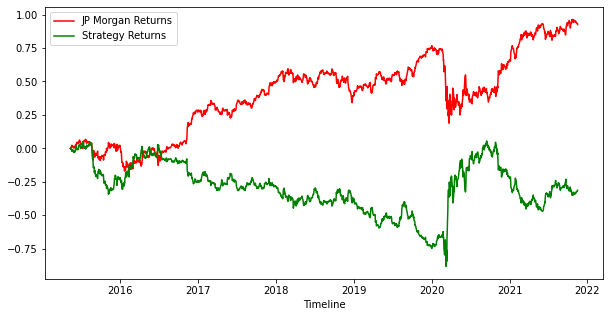

In [51]:
tsla2['Predicted Signal'] = model.predict(X)
tsla2['Returns'] = np.log(tsla2['Close']/tsla2['Close'].shift(1))
cumsum_tsla_ret = np.cumsum(tsla2[split:]['Returns'])

tsla2['Strategy'] = tsla2['Returns'] * tsla2['Predicted Signal'].shift(1)
cumsum_tsla_st = np.cumsum(tsla2[split:]['Strategy'])

plt.figure(figsize=(10,5))
plt.plot(cumsum_tsla_ret, color='r',label = 'JP Morgan Returns')
plt.plot(cumsum_tsla_st, color='g', label = 'Strategy Returns')
plt.xlabel('Timeline')
plt.legend()
plt.show()

### k-Nearest Neighbors

In [52]:
# Read In Data
tsla = pd.read_csv('Data/JPM.csv', sep = ",")
tsla3 = tsla.dropna()
tsla3.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,49.833332,50.250000,48.083332,48.583332,25.561586,12019200
1,2000-01-04,47.083332,47.458332,46.125000,47.250000,25.000719,11723400
2,2000-01-05,46.833332,48.375000,46.000000,46.958332,24.846399,8714550
3,2000-01-06,46.750000,48.625000,46.500000,47.625000,25.199142,8369250
4,2000-01-07,48.416668,49.000000,47.333332,48.500000,25.662115,6571950


In [53]:
tsla3 = tsla3[['Open', 'High', 'Close', 'Low']]
tsla3['Open-Close'] = tsla3.Open - tsla3.Close
tsla3['High-Low'] = tsla3.High = tsla3.Low
tsla3 = tsla3.dropna()
X_knn = tsla3[['Open-Close', 'High-Low']]

Y_knn = np.where(tsla3['Close'].shift(-1) > tsla3['Close'], 1, -1)

split3 = int(0.7 * len(tsla3))

X_train_knn = X_knn[:split3]
Y_train_knn = Y_knn[:split3]
X_test_knn = X_knn[split3:]
Y_test_knn = Y_knn[split3:]

In [54]:
knn = KNeighborsClassifier(n_neighbors = 15)
knn.fit(X_train_knn, Y_train_knn)


KNeighborsClassifier(n_neighbors=15)

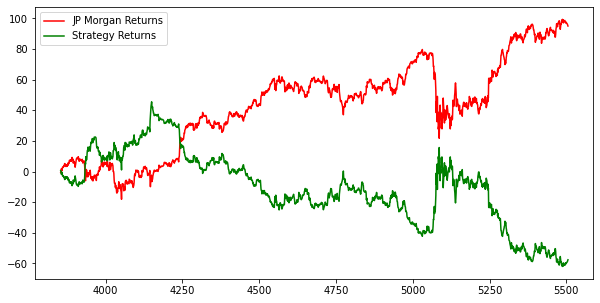

In [55]:
tsla3['Predicted'] = knn.predict(X_knn)
tsla3['Returns'] = np.log(tsla3['Close']/tsla3['Close'].shift(1))
cumsum_ret = tsla3[split3:]['Returns'].cumsum() * 100
tsla3['Strategy'] = tsla3['Returns'] * tsla3['Predicted'].shift(1)
cumsum_stra = tsla3[split3:]['Strategy'].cumsum() * 100

plt.figure(figsize = (10,5))
plt.plot(cumsum_ret, color='r',label = 'JP Morgan Returns')
plt.plot(cumsum_stra, color='g', label = 'Strategy Returns')
plt.legend()
plt.show()

In [56]:
train = []
test = []

for i in range(1, 151, 5):
    knn2 = KNeighborsClassifier(n_neighbors = i * 10)
    knn2.fit(X_train_knn, Y_train_knn)
    train.append(accuracy_score(Y_train_knn, knn2.predict(X_train_knn)))
    test.append(accuracy_score(Y_test_knn, knn2.predict(X_test_knn)))

print("Average of the training set =", round(sum(train)/len(train), 2))
print("Average of the testing set =", round(sum(test)/len(test), 2))

Average of the training set = 0.52
Average of the testing set = 0.5


### LSTM

In [57]:
# Read In Data
tsla = pd.read_csv('Data/JPM.csv', sep = ",")
tsla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,49.833332,50.250000,48.083332,48.583332,25.561586,12019200
1,2000-01-04,47.083332,47.458332,46.125000,47.250000,25.000719,11723400
2,2000-01-05,46.833332,48.375000,46.000000,46.958332,24.846399,8714550
3,2000-01-06,46.750000,48.625000,46.500000,47.625000,25.199142,8369250
4,2000-01-07,48.416668,49.000000,47.333332,48.500000,25.662115,6571950


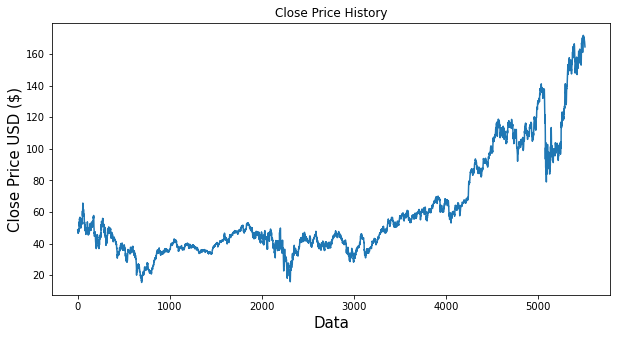

In [58]:
plt.figure(figsize = (10,5))
plt.title('Close Price History')
plt.plot(tsla['Close'])
plt.xlabel('Data', fontsize=15 )
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.show()

In [59]:
#Create a dataframe with only the 'Create Column
data = tsla.filter(['Close'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len= math.ceil(len(dataset)* 0.85)

In [60]:
#Scale the all of the data to be values between 0 and 1 
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [61]:
#Create the scaled training data set 
train_data = scaled_data[0:training_data_len  , : ]
#Split the data into x_train and y_train data sets
x_train=[]
y_train = []
for i in range(180,len(train_data)):
    x_train.append(train_data[i-180:i,0])
    y_train.append(train_data[i,0])

In [62]:
x_train, y_train = np.array(x_train), np.array(y_train)
#Reshape the data into the shape accepted by the LSTM
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [63]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True,input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [64]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
# Train the model
model.fit(x_train, y_train, batch_size=32, epochs=15)

Epoch 1/15
141/141 [==============================] - 38s 228ms/step - loss: 0.0026
Epoch 2/15
141/141 [==============================] - 35s 245ms/step - loss: 6.6406e-04
Epoch 3/15
141/141 [==============================] - 37s 259ms/step - loss: 5.8330e-04
Epoch 4/15
141/141 [==============================] - 39s 279ms/step - loss: 4.9715e-04
Epoch 5/15
141/141 [==============================] - 37s 260ms/step - loss: 4.8350e-04
Epoch 6/15
141/141 [==============================] - 36s 257ms/step - loss: 4.8179e-04
Epoch 7/15
141/141 [==============================] - 37s 261ms/step - loss: 4.3849e-04
Epoch 8/15
141/141 [==============================] - 36s 252ms/step - loss: 3.7776e-04
Epoch 9/15
141/141 [==============================] - 35s 247ms/step - loss: 3.6853e-04
Epoch 10/15
141/141 [==============================] - 35s 247ms/step - loss: 3.5112e-04
Epoch 11/15
141/141 [==============================] - 42s 301ms/step - loss: 3.4820e-04
Epoch 12/15
141/141 [=============

In [65]:
# Test data set
test_data = scaled_data[training_data_len - 180: , : ]
# Create the x_test and y_test data sets
x_test = []
y_test =  dataset[training_data_len : , : ] 
for i in range(180,len(test_data)):
    x_test.append(test_data[i-180:i,0])

In [66]:
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))
# Getting the models predicted price values
predictions = model.predict(x_test) 
predictions = scaler.inverse_transform(predictions)
# Undo scaling
rmse = math.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)

print(rmse)
print(mae)

3.9023383656538764
2.8685069728835226


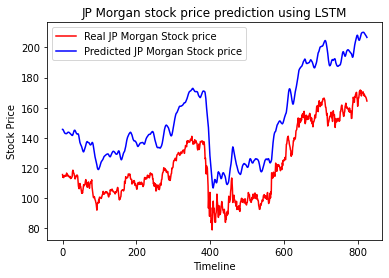

In [67]:
# Visualising the results
plt.plot(y_test,color='red',label='Real JP Morgan Stock price')
plt.plot(predictions/0.8,color='blue',label='Predicted JP Morgan Stock price')
plt.title('JP Morgan stock price prediction using LSTM')
plt.xlabel('Timeline')
plt.ylabel('Stock Price')
plt.legend()
plt.show()